# Annotate RBC-GEM
Read annotation tables and annotate the model 
## Setup
### Import packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from rbc_gem_utils import (
    GEM_NAME,
    compare_tables,
    explode_column,
    get_annotation_df,
    get_dirpath,
    read_cobra_model,
    show_versions,
    split_string,
    visualize_comparison,
    write_cobra_model,
)
from rbc_gem_utils.annotation import set_sbo_default_annotations

# Display versions of last time notebook ran and worked
show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.2

Dependency Information
----------------------
beautifulsoup4                       4.13.4
bio                                   1.8.0
cobra                                0.29.1
depinfo                               2.2.0
gurobipy                             12.0.2
matplotlib                           3.10.3
matplotlib-venn                       1.1.2
memote                               0.17.0
networkx                              3.4.2
notebook                              7.4.2
openpyxl                              3.1.5
pandas                                2.2.3
pre-commit                            4.2.0
rbc-gem-utils[database,network,vis] missing
requests                             2.32.3
scipy                                1.15.3
seaborn                              0.13.2

Build Tools Information
-----------------------
pip          25.1
setuptools 78.1.1
wheel      0.45.1

Platform Information
-------------------

## Load RBC-GEM model

In [2]:
model_dirpath = get_dirpath("model")

old_model = read_cobra_model(filename=model_dirpath / f"{GEM_NAME}.xml")
new_model = read_cobra_model(filename=model_dirpath / f"{GEM_NAME}.xml")

Set parameter Username
Set parameter LicenseID to value 2664191
Academic license - for non-commercial use only - expires 2026-05-12


## Set annotations on model

In [3]:
# Whether to update dictionaries or replace dictionaries entirely
reset_and_replace_annotation_dict = True
reset_sbo = True  # Using this option resets the model SBO terms to default values
annotation_types = ["reactions", "metabolites", "genes"]

for annotation_type in annotation_types:
    df_annotation = pd.read_csv(
        model_dirpath / f"{annotation_type}.tsv",
        sep="\t",
        index_col=None,
        dtype=str,
    )
    previous_id_mapping_df = pd.read_csv(
        get_dirpath("deprecatedIdentifiers")
        / f"{annotation_type}_deprecatedIdentifiers.tsv",
        sep="\t",
        index_col=None,
    )
    retired_col = [c for c in previous_id_mapping_df.columns if c.endswith("Retired")][
        0
    ]

    for idx, row in df_annotation.set_index(annotation_type).iterrows():
        try:
            item = getattr(new_model, annotation_type).get_by_id(idx)
        except KeyError:
            # Check if ID was retired for another name
            df_retired = previous_id_mapping_df[
                previous_id_mapping_df[retired_col].apply(
                    lambda x: idx in split_string(x)
                )
            ]
            if not df_retired.empty:
                print(
                    f"{idx} was renamed to {df_retired.iloc[:, 0].item()}, making ID correction"
                )
                idx = df_retired.iloc[:, 0].item()
                item = getattr(new_model, annotation_type).get_by_id(idx)
            else:
                print(f"Not found, was this removed? {annotation_type}, {idx}")
                continue
        values = {k: split_string(v) for k, v in row.dropna().to_dict().items()}
        values.update({k: v[0] for k, v in values.items() if len(v) == 1})
        if reset_and_replace_annotation_dict:
            item.annotation = values
        else:
            item.annotation.update(values)

if reset_sbo:
    set_sbo_default_annotations(new_model, annotation_types, verbose=False)

### Compare before overwriting

In [4]:
df_old_model = {}
for annotation_type in annotation_types:
    all_annotation_keys = set()
    for annotation in getattr(old_model, annotation_type).list_attr("annotation"):
        all_annotation_keys.update(list(annotation.keys()))
    # Get annotation df is agnostic to object type, swap ID column with the `annotation_type`
    df_old_model[annotation_type] = get_annotation_df(
        getattr(old_model, annotation_type), sorted(list(all_annotation_keys))
    ).rename({"id": annotation_type}, axis=1)
    df_old_model[annotation_type] = df_old_model[annotation_type].sort_values(
        annotation_type
    )

df_new_model = {}
for annotation_type in annotation_types:
    all_annotation_keys = set()
    for annotation in getattr(new_model, annotation_type).list_attr("annotation"):
        all_annotation_keys.update(list(annotation.keys()))
    # Get annotation df is agnostic to object type, swap ID column with the `annotation_type`
    df_new_model[annotation_type] = get_annotation_df(
        getattr(new_model, annotation_type), sorted(list(all_annotation_keys))
    ).rename({"id": annotation_type}, axis=1)
    df_new_model[annotation_type] = df_new_model[annotation_type].sort_values(
        annotation_type
    )

<Axes: xlabel='reactions'>

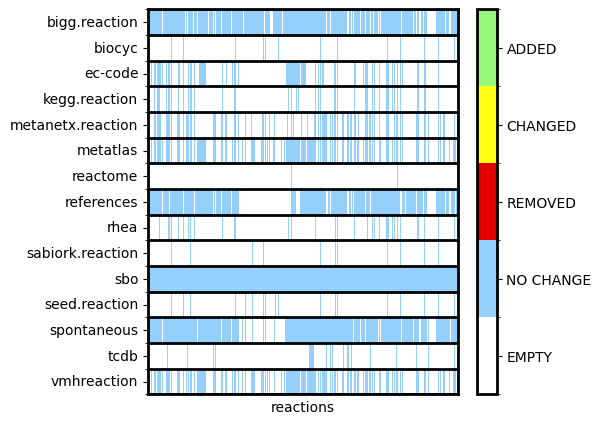

In [5]:
annotation_type = "reactions"
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

df_comparision = compare_tables(
    df_old_model[annotation_type].set_index(annotation_type),
    df_new_model[annotation_type].set_index(annotation_type),
)
visualize_comparison(df_comparision)

<Axes: xlabel='metabolites'>

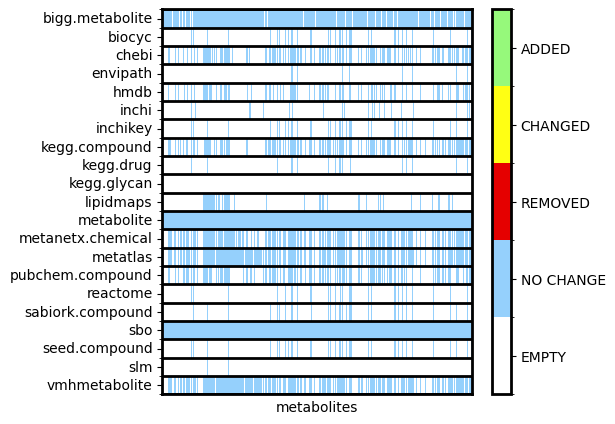

In [6]:
annotation_type = "metabolites"
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
df_comparision = compare_tables(
    df_old_model[annotation_type].set_index(annotation_type),
    df_new_model[annotation_type].set_index(annotation_type),
)
visualize_comparison(df_comparision)

<Axes: xlabel='genes'>

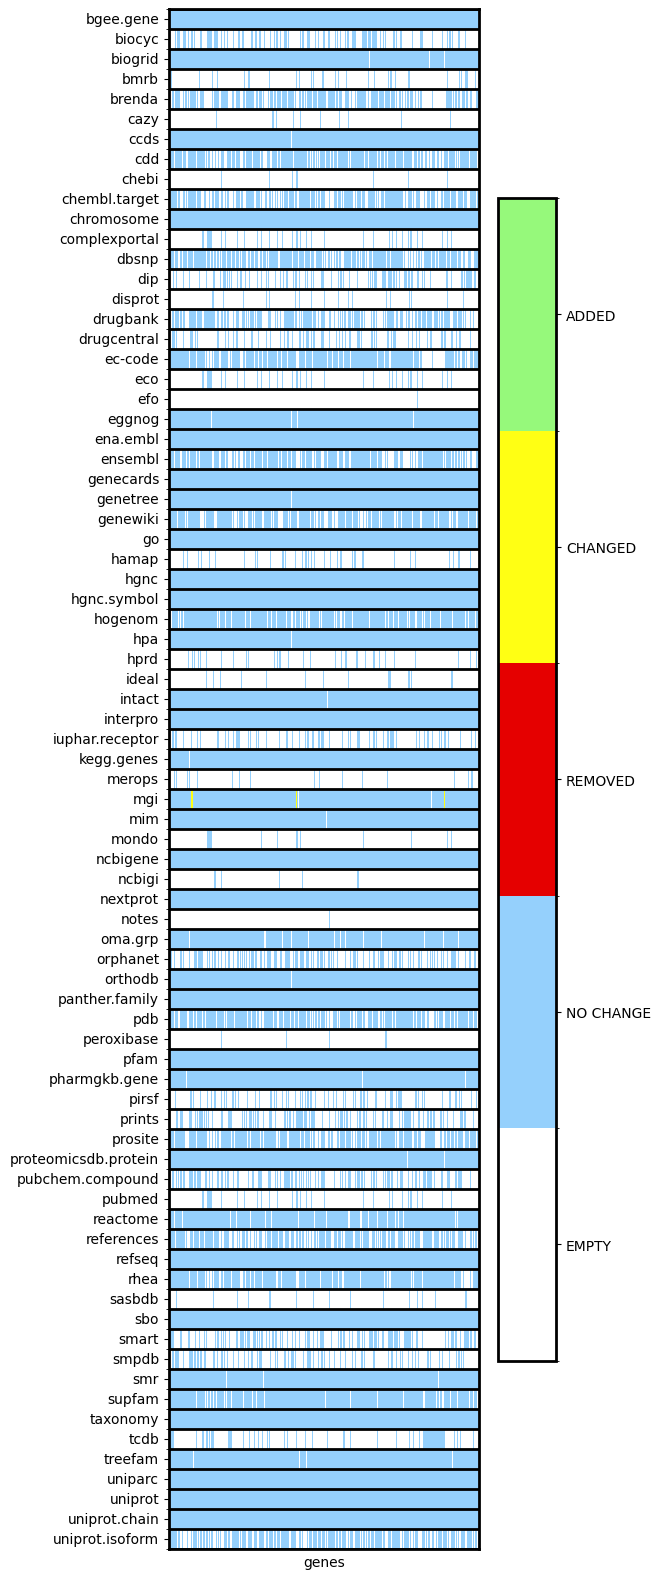

In [7]:
annotation_type = "genes"
fig, ax = plt.subplots(1, 1, figsize=(5, 20))

df_comparision = compare_tables(
    df_old_model[annotation_type].set_index(annotation_type),
    df_new_model[annotation_type].set_index(annotation_type),
)
visualize_comparison(df_comparision)

## Export model for all filetypes

In [8]:
for ftype in ["xml", "mat", "json", "yml"]:
    write_cobra_model(new_model, model_dirpath / f"{GEM_NAME}.{ftype}")

## Extract annotations from model

In [9]:
compare_figsize = (10, 5)
compare = True
display_nunique = True
overwrite = True

### Reactions

reactions: 3275
bigg.reaction: 3491
biocyc: 188
ec-code: 385
kegg.reaction: 525
metanetx.reaction: 1153
metatlas: 1596
reactome: 14
references: 972
rhea: 442
sabiork.reaction: 149
sbo: 4
seed.reaction: 288
spontaneous: 2
tcdb: 31
vmhreaction: 1626


,reactions,bigg.reaction,biocyc,ec-code,kegg.reaction,metanetx.reaction,metatlas,reactome,references,rhea,sabiork.reaction,sbo,seed.reaction,spontaneous,tcdb,vmhreaction
0,UNK3,UNK3,META:RXN-14147,2.6.1.5,R07396,MNXR95923,MAR05391,<NA>,pubmed:27491795,25796.0,<NA>,SBO:0000176,rxn05108,0.0,<NA>,UNK3r
1,4PYRDXABCte,4PYRDX;4PYRDXABCte,<NA>,<NA>,<NA>,MNXR95053,MAR08103,<NA>,pubmed:7598051,<NA>,<NA>,SBO:0000185,<NA>,0.0,<NA>,4PYRDX
2,5AOPt2,5AOPt2,<NA>,<NA>,<NA>,MNXR95061,MAR11307,<NA>,pubmed:11772241;pubmed:27641616;pubmed:3006167...,<NA>,<NA>,SBO:0000185,rxn09702,0.0,<NA>,5AOPt2
3,EX_ade_e,EX_ade_e,META:TRANS-RXN0-577,<NA>,<NA>,<NA>,MAR09250,<NA>,<NA>,<NA>,<NA>,SBO:0000627,rxn10918;rxn08065;rxn09786,0.0,<NA>,EX_acnacngal14acglcgalgluside_hs[e]
4,EX_adn_e,EX_adn_e,<NA>,<NA>,<NA>,<NA>,MAR09251,<NA>,<NA>,<NA>,<NA>,SBO:0000627,rxn08069;rxn11000,0.0,<NA>,EX_acnacngalgbside_hs[e]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3270,SK_avite1qn_c,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,SBO:0000632,<NA>,<NA>,<NA>,<NA>
3271,SK_prdx2crd_c,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,SBO:0000632,<NA>,<NA>,<NA>,<NA>
3272,SK_prdx2cso3_c,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,SBO:0000632,<NA>,<NA>,<NA>,<NA>
3273,SK_grdx2crd_c,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,SBO:0000632,<NA>,<NA>,<NA>,<NA>


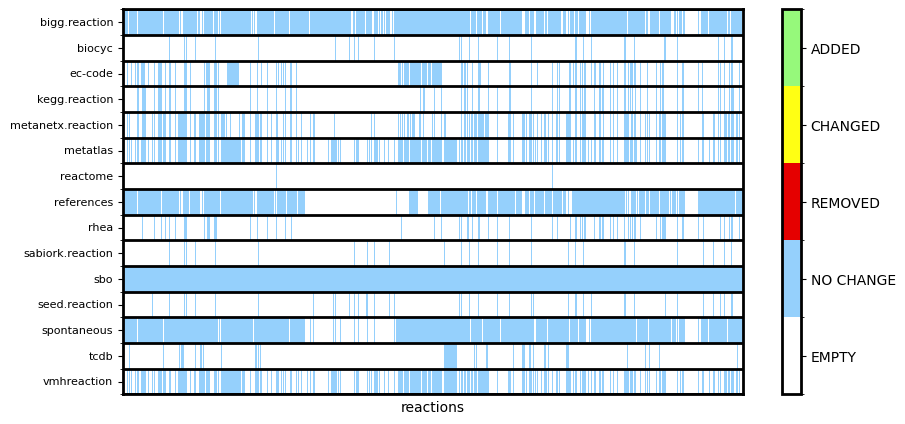

In [10]:
annotation_type = "reactions"
all_annotation_keys = set()
for annotation in getattr(new_model, annotation_type).list_attr("annotation"):
    all_annotation_keys.update(list(annotation.keys()))
# Get annotation df is agnostic to object type, swap ID column with the `annotation_type`
df_annotations = get_annotation_df(
    getattr(new_model, annotation_type), sorted(list(all_annotation_keys))
).rename({"id": annotation_type}, axis=1)


df_annotations = df_annotations.replace(float("nan"), pd.NA).replace("", pd.NA)
if compare:
    compare_on_index = [annotation_type]
    try:
        df_previous = pd.read_csv(
            model_dirpath / f"{annotation_type}.tsv", sep="\t", index_col=None
        )
        df_previous = df_previous.replace(float("nan"), pd.NA).replace("", pd.NA)
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=compare_on_index)
    df_comparision = compare_tables(
        df_previous.set_index(compare_on_index),
        df_annotations.set_index(compare_on_index),
    )

    fig, ax = plt.subplots(1, 1, figsize=compare_figsize)
    ax.yaxis.set_tick_params(labelsize=8)
    ax = visualize_comparison(df_comparision)

if display_nunique:
    for col in df_annotations.columns:
        df = explode_column(df_annotations, name=col, sep=";")
        df = df[col].drop_duplicates()
        print(f"{df.name}: {df.nunique()}")

if overwrite:
    df_annotations.to_csv(
        model_dirpath / f"{annotation_type}.tsv", sep="\t", index=False
    )

df_annotations

### Metabolites

metabolites: 2157
bigg.metabolite: 1571
biocyc: 212
chebi: 694
envipath: 72
hmdb: 418
inchi: 129
inchikey: 184
kegg.compound: 767
kegg.drug: 64
kegg.glycan: 6
lipidmaps: 224
metabolite: 1685
metanetx.chemical: 1173
metatlas: 1410
pubchem.compound: 676
reactome: 455
sabiork.compound: 218
sbo: 1
seed.compound: 224
slm: 7
vmhmetabolite: 1141


,metabolites,bigg.metabolite,biocyc,chebi,envipath,hmdb,inchi,inchikey,kegg.compound,kegg.drug,...,metabolite,metanetx.chemical,metatlas,pubchem.compound,reactome,sabiork.compound,sbo,seed.compound,slm,vmhmetabolite
0,13dpg_c,13dpg,META:DPG,CHEBI:16001,<NA>,<NA>,<NA>,LJQLQCAXBUHEAZ-UWTATZPHSA-J,C00236,<NA>,...,13dpg,MNXM261,MAM00247c,439191.0,29800,21215,SBO:0000247,cpd00203,<NA>,13dpg
1,23dpg_c,23dpg,META:23-DIPHOSPHOGLYCERATE,CHEBI:17720,<NA>,<NA>,<NA>,XOHUEYCVLUUEJJ-UWTATZPHSA-I,C01159,<NA>,...,23dpg,MNXM146487;MNXM892,MAM00569c,<NA>,6798337,20899;1355,SBO:0000247,cpd00853;cpd02119,<NA>,23dpg
2,2kmb_c,2kmb,META:CPD-479,CHEBI:33574,<NA>,<NA>,<NA>,SXFSQZDSUWACKX-UHFFFAOYSA-M,C01180,<NA>,...,2kmb,MNXM276,MAM01016c,<NA>,1237122,5424,SBO:0000247,cpd00869,<NA>,2kmb
3,2pg_c,2pg,META:2-PG,CHEBI:17835,<NA>,<NA>,<NA>,GXIURPTVHJPJLF-UWTATZPHSA-K,C00631,<NA>,...,2pg,MNXM275,MAM00674c,439278.0,30485,31,SBO:0000247,cpd00482,<NA>,2pg
4,35cgmp_c,35cgmp,META:CGMP,CHEBI:16356,<NA>,HMDB0001314,<NA>,ZOOGRGPOEVQQDX-UUOKFMHZSA-M,C00942,<NA>,...,35cgmp,MNXM665,MAM01433c,24316.0,<NA>,<NA>,SBO:0000247,cpd00697,<NA>,35cgmp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2152,3mob_e,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,3mob,<NA>,<NA>,<NA>,<NA>,<NA>,SBO:0000247,<NA>,<NA>,<NA>
2153,crm_hs_e,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,crm_hs,<NA>,<NA>,<NA>,<NA>,<NA>,SBO:0000247,<NA>,<NA>,<NA>
2154,alltn_e,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,alltn,<NA>,<NA>,<NA>,<NA>,<NA>,SBO:0000247,<NA>,<NA>,<NA>
2155,3dfru_e,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,3dfru,<NA>,<NA>,<NA>,<NA>,<NA>,SBO:0000247,<NA>,<NA>,<NA>


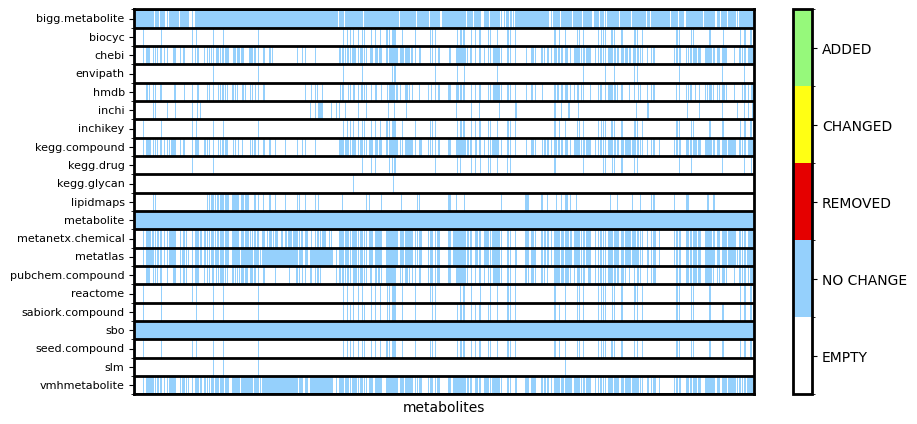

In [11]:
annotation_type = "metabolites"
all_annotation_keys = set()
for annotation in getattr(new_model, annotation_type).list_attr("annotation"):
    all_annotation_keys.update(list(annotation.keys()))
# Get annotation df is agnostic to object type, swap ID column with the `annotation_type`
df_annotations = get_annotation_df(
    getattr(new_model, annotation_type), sorted(list(all_annotation_keys))
).rename({"id": annotation_type}, axis=1)

df_annotations = df_annotations.replace(float("nan"), pd.NA).replace("", pd.NA)
if compare:
    compare_on_index = [annotation_type]
    try:
        df_previous = pd.read_csv(
            model_dirpath / f"{annotation_type}.tsv", sep="\t", index_col=None
        )
        df_previous = df_previous.replace(float("nan"), pd.NA).replace("", pd.NA)
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=compare_on_index)
    df_comparision = compare_tables(
        df_previous.set_index(compare_on_index),
        df_annotations.set_index(compare_on_index),
    )

    fig, ax = plt.subplots(1, 1, figsize=compare_figsize)
    ax.yaxis.set_tick_params(labelsize=8)
    ax = visualize_comparison(df_comparision)

if display_nunique:
    for col in df_annotations.columns:
        df = explode_column(df_annotations, name=col, sep=";")
        df = df[col].drop_duplicates()
        print(f"{df.name}: {df.nunique()}")

if overwrite:
    df_annotations.to_csv(
        model_dirpath / f"{annotation_type}.tsv", sep="\t", index=False
    )

df_annotations

### Genes

genes: 820
bgee.gene: 819
biocyc: 298
biogrid: 821
bmrb: 88
brenda: 413
cazy: 21
ccds: 1421
cdd: 661
chebi: 9
chembl.target: 530
chromosome: 25
complexportal: 360
dbsnp: 5070
dip: 248
disprot: 47
drugbank: 2712
drugcentral: 687
ec-code: 538
eco: 5
efo: 1
eggnog: 614
ena.embl: 8407
ensembl: 557
genecards: 821
genetree: 744
genewiki: 621
go: 5849
hamap: 92
hgnc: 821
hgnc.symbol: 821
hogenom: 591
hpa: 819
hprd: 90
ideal: 43
intact: 813
interpro: 2119
iuphar.receptor: 188
kegg.genes: 824
merops: 41
mgi: 864
mim: 1387
mondo: 32
ncbigene: 822
ncbigi: 108
nextprot: 820
notes: 4
oma.grp: 785
orphanet: 537
orthodb: 590
panther.family: 1235
pdb: 12718
peroxibase: 13
pfam: 784
pharmgkb.gene: 814
pirsf: 152
prints: 198
prosite: 412
proteomicsdb.protein: 1752
pubchem.compound: 1166
pubmed: 368
reactome: 1081
references: 666
refseq: 3668
rhea: 1530
sasbdb: 46
sbo: 1
smart: 184
smpdb: 648
smr: 808
supfam: 322
taxonomy: 1
tcdb: 151
treefam: 616
uniparc: 820
uniprot: 820
uniprot.chain: 871
uniprot.isof

,genes,bgee.gene,biocyc,biogrid,bmrb,brenda,cazy,ccds,cdd,chebi,...,smpdb,smr,supfam,taxonomy,tcdb,treefam,uniparc,uniprot,uniprot.chain,uniprot.isoform
0,RPE,ENSG00000197713,<NA>,112040,<NA>,5.1.3.1,<NA>,CCDS2388.1;CCDS42810.1;CCDS63107.1;CCDS63108.1,cd00429,<NA>,...,SMP0000031;SMP0000518;SMP0000519;SMP0000520,Q96AT9,SSF51366,9606,<NA>,TF300157,UPI0000037A9A,Q96AT9,PRO_0000171587,Q96AT9-1;Q96AT9-2;Q96AT9-3;Q96AT9-4;Q96AT9-5
1,RPIA,ENSG00000153574,<NA>,116594,<NA>,5.3.1.6,<NA>,CCDS2004.2,cd01398,<NA>,...,SMP0000031;SMP0000518;SMP0000519;SMP0000520;SM...,P49247,SSF75445;SSF100950,9606,<NA>,TF105758,UPI0000037A98,P49247,PRO_0000158521,<NA>
2,SORD,ENSG00000140263,<NA>,112535,<NA>,1.1.1.14,<NA>,CCDS10116.1,cd05285,<NA>,...,SMP0000064;SMP0000561;SMP0000725,Q00796,SSF50129;SSF51735,9606,<NA>,TF313060,UPI000013D771,Q00796,PRO_0000160817,Q00796-1;Q00796-2
3,AKR7A2,ENSG00000053371,MetaCyc:ENSG00000053371-MONOMER,114142,<NA>,<NA>,<NA>,CCDS194.1,cd19075,<NA>,...,<NA>,O43488,SSF51430,9606,<NA>,TF329173,UPI00001D965B,O43488,PRO_0000070375,<NA>
4,SRM,ENSG00000116649,MetaCyc:HS04027-MONOMER,112601,<NA>,2.5.1.16,<NA>,CCDS125.1,cd02440,<NA>,...,SMP0000033;SMP0000177;SMP0000214;SMP0000221;SM...,P19623,SSF53335,9606,<NA>,TF314466,UPI0000049054,P19623,PRO_0000156445,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,USP5,ENSG00000111667,<NA>,113751,<NA>,3.4.19.12,<NA>,CCDS31733.1;CCDS41743.1,cd02658;cd14383;cd14386,<NA>,...,<NA>,P45974,SSF54001;SSF57850;SSF46934,9606,<NA>,TF300576,UPI00001379E1,P45974,PRO_0000080623,P45974-1;P45974-2
816,VCPIP1,ENSG00000175073,<NA>,123125,<NA>,<NA>,<NA>,CCDS6192.1,cd22769;cd17059,<NA>,...,<NA>,Q96JH7,SSF54236,9606,<NA>,TF329469,UPI00001D3EF3,Q96JH7,PRO_0000065769,<NA>
817,VPS4B,ENSG00000119541,<NA>,114901,<NA>,<NA>,<NA>,CCDS11983.1,cd02678;cd19521,<NA>,...,<NA>,O75351,SSF116846;SSF52540,9606,<NA>,TF105012,UPI0000073CAF,O75351,PRO_0000084767,<NA>
818,WDR77,ENSG00000116455,<NA>,122532,<NA>,<NA>,<NA>,CCDS835.1,<NA>,<NA>,...,<NA>,Q9BQA1,SSF50978,9606,<NA>,TF325967,UPI0000047AC6,Q9BQA1,PRO_0000051074,Q9BQA1-1;Q9BQA1-2


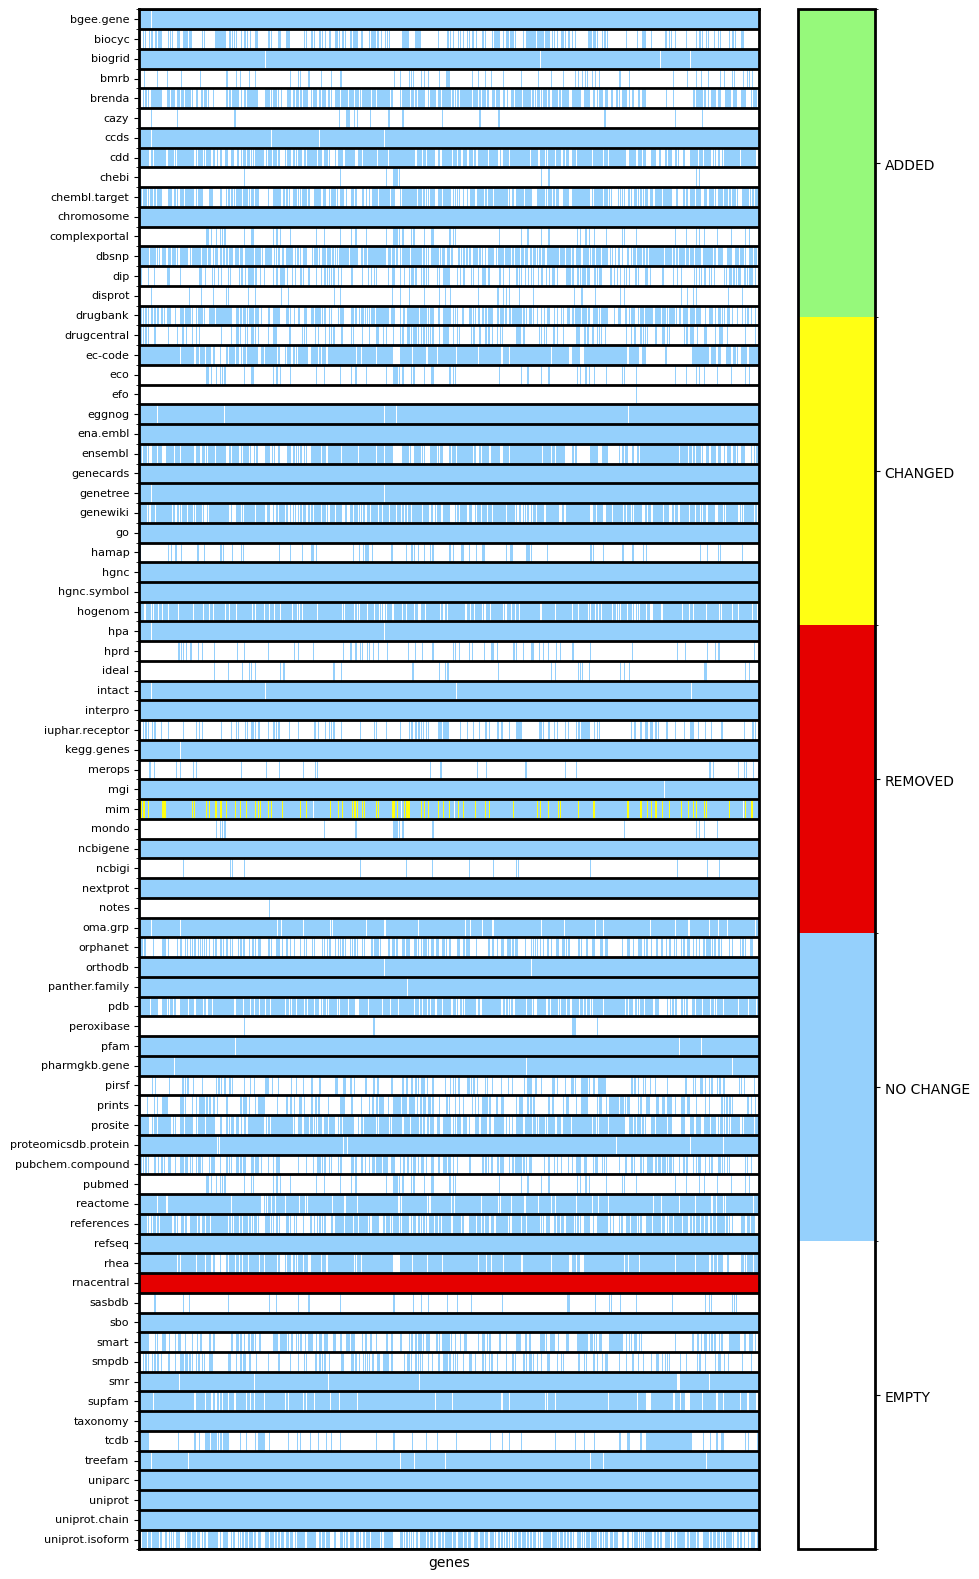

In [12]:
annotation_type = "genes"
all_annotation_keys = set()
for annotation in getattr(new_model, annotation_type).list_attr("annotation"):
    all_annotation_keys.update(list(annotation.keys()))
# Get annotation df is agnostic to object type, swap ID column with the `annotation_type`
df_annotations = get_annotation_df(
    getattr(new_model, annotation_type), sorted(list(all_annotation_keys))
).rename({"id": annotation_type}, axis=1)

df_annotations = df_annotations.replace(float("nan"), pd.NA).replace("", pd.NA)
if compare:
    compare_on_index = [annotation_type]
    try:
        df_previous = pd.read_csv(
            model_dirpath / f"{annotation_type}.tsv", sep="\t", index_col=None
        )
        df_previous = df_previous.replace(float("nan"), pd.NA).replace("", pd.NA)
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=compare_on_index)
    df_comparision = compare_tables(
        df_previous.set_index(compare_on_index),
        df_annotations.set_index(compare_on_index),
    )

    fig, ax = plt.subplots(1, 1, figsize=(10, 20))
    ax.yaxis.set_tick_params(labelsize=8)
    ax = visualize_comparison(df_comparision)

if display_nunique:
    for col in df_annotations.columns:
        df = explode_column(df_annotations, name=col, sep=";")
        df = df[col].drop_duplicates()
        print(f"{df.name}: {df.nunique()}")

if overwrite:
    df_annotations.to_csv(
        model_dirpath / f"{annotation_type}.tsv", sep="\t", index=False
    )

df_annotations